In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D

from keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import swish, relu,selu

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

train_set= ('./Experiments/data_pre/mel_spectrogram_imgs/train')
test_set=('./Experiments/data_pre/mel_spectrogram_imgs/test')
val_set= ('./Experiments/data_pre/mel_spectrogram_imgs/val')

train_datagen = image.ImageDataGenerator(rescale= 1./255)
val_datagen= image.ImageDataGenerator(rescale= 1./255)
test_datagen= image.ImageDataGenerator(rescale= 1./255)


train_generator = train_datagen.flow_from_directory(train_set,batch_size =512 ,class_mode = 'categorical')
test_generator = test_datagen.flow_from_directory(test_set,shuffle=True,batch_size =128 ,class_mode = 'categorical')
validation_generator = test_datagen.flow_from_directory(val_set,shuffle=True,batch_size =128 ,class_mode = 'categorical')
x_train, y_train = next(train_generator)
x_val,y_val= next(validation_generator)
x_test, y_test = next(test_generator)

2024-05-03 13:00:49.496602: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-03 13:00:49.515537: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-03 13:00:49.515557: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-03 13:00:49.516054: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-03 13:00:49.519632: I tensorflow/core/platform/cpu_feature_guar

Found 699 images belonging to 10 classes.
Found 151 images belonging to 10 classes.
Found 149 images belonging to 10 classes.


In [2]:
best_params = {'layer_size_1': 94, 'layer_size_2': 3975, 'layer_size_3': 3413, 'dropout_rate_1': 0.18493564427131048, 'dropout_rate_2': 0.17272998688284025, 'dropout_rate_3': 0.17336180394137352, 'activation': 'swish', 'learning_rate': 0.0001461896279370495}


In [3]:
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint

# Define the hyperparameters
layer_size_1 = best_params['layer_size_1']
layer_size_2 = best_params['layer_size_2']
layer_size_3 = best_params['layer_size_3']
dropout_rate_1 = best_params['dropout_rate_1']
dropout_rate_2 = best_params['dropout_rate_2']
dropout_rate_3 = best_params['dropout_rate_3']
activation = best_params['activation']
learning_rate = best_params['learning_rate']


base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the layers in the base model
for layer in base_model.layers[:-1]: #####   modify the number of layers
    layer.trainable = False

# Create a new model
model = Sequential()

# Add the VGG16 base model to the new model
model.add(base_model)
model.add(Flatten())
model.add(Dense(layer_size_1, input_shape=(x_train.shape[1],)))
model.add(Activation(activation))
model.add(Dropout(dropout_rate_1))


model.add(Dense(layer_size_2))
model.add(Activation(activation))
model.add(Dropout(dropout_rate_2))


model.add(Dense(layer_size_3))
model.add(Activation(activation))
model.add(Dropout(dropout_rate_3))

model.add(Dense(10, activation='softmax'))

# Compile the model with hyperparameters
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with hyperparameters
csv_logger = CSVLogger('./logs/VGG_r2_training.csv')
# Define the checkpoint callback
checkpoint = ModelCheckpoint(filepath='./model_weights/VGG_r2_model_weights.h5', 
                             monitor='val_loss', 
                             save_best_only=True,
                             save_weights_only=True,
                             mode='min',
                             verbose=1)


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, mode='min', min_delta=0.0001, restore_best_weights=True)
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=150, callbacks=[early_stopping,checkpoint,csv_logger], verbose=1)


2024-05-03 13:00:57.688300: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-03 13:00:57.705373: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-03 13:00:57.705402: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-03 13:00:57.708555: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-03 13:00:57.708589: I external/local_xla/xla/stream_executor

Epoch 1/150


2024-05-03 13:00:59.063269: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-05-03 13:00:59.153038: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-03 13:01:01.263805: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-03 13:01:01.576673: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fc0878df150 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-03 13:01:01.576695: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2024-05-03 13:01:01.579611: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1714737661.622779   69928 devic

16/16 [==============================] - ETA: 0s - loss: 2.3185 - accuracy: 0.1133
Epoch 1: val_loss improved from inf to 2.26807, saving model to ./model_weights/VGG_r2_model_weights.h5
16/16 [==============================] - 6s 162ms/step - loss: 2.3185 - accuracy: 0.1133 - val_loss: 2.2681 - val_accuracy: 0.1797
Epoch 2/150
16/16 [==============================] - ETA: 0s - loss: 2.1864 - accuracy: 0.1836
Epoch 2: val_loss improved from 2.26807 to 2.14815, saving model to ./model_weights/VGG_r2_model_weights.h5
16/16 [==============================] - 2s 148ms/step - loss: 2.1864 - accuracy: 0.1836 - val_loss: 2.1481 - val_accuracy: 0.1797
Epoch 3/150
16/16 [==============================] - ETA: 0s - loss: 1.9914 - accuracy: 0.2363
Epoch 3: val_loss improved from 2.14815 to 1.96908, saving model to ./model_weights/VGG_r2_model_weights.h5
16/16 [==============================] - 2s 148ms/step - loss: 1.9914 - accuracy: 0.2363 - val_loss: 1.9691 - val_accuracy: 0.3047
Epoch 4/150
16

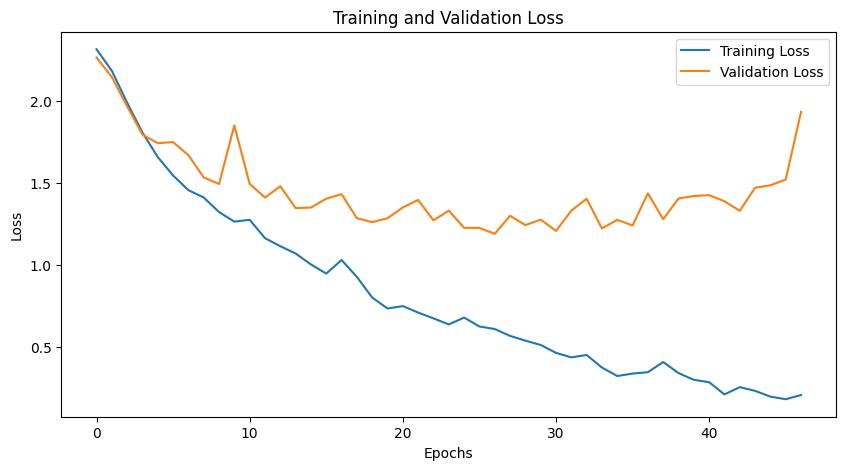

<Figure size 640x480 with 0 Axes>

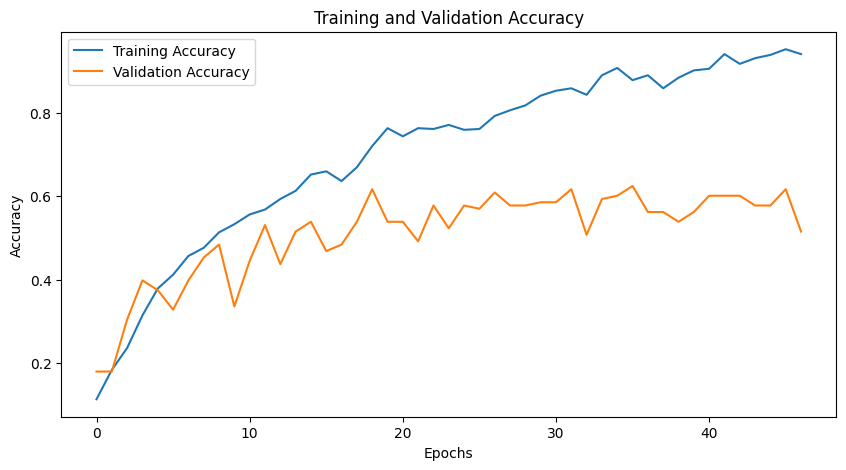

<Figure size 640x480 with 0 Axes>

In [4]:
import matplotlib.pyplot as plt

# Get the training and validation loss from the history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Get the training and validation accuracy from the history
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig('./img/VGG_r2_loss_plot.png')

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.savefig('./img/VGG_r2_accuracy_plot.png')



In [5]:
model.evaluate(x_test, y_test)


4/4 [==============================] - 0s 107ms/step - loss: 1.1666 - accuracy: 0.6484


[1.1665939092636108, 0.6484375]

4/4 [==============================] - 0s 106ms/step


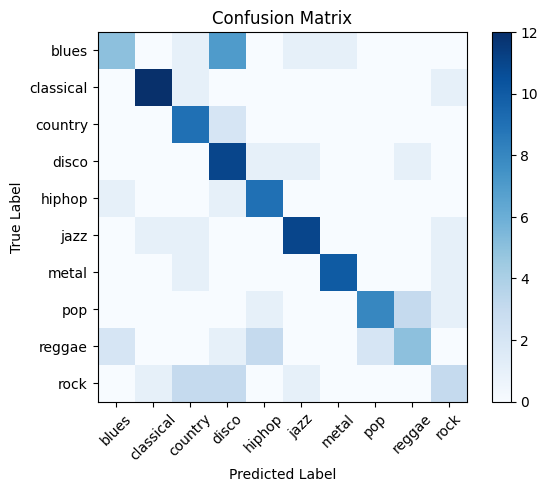

F1 Score: 0.6384884906759907


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score

classes = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

# Assuming you have the predicted labels and true labels
y_pred = model.predict(x_test).argmax(axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate the F1 score
f1 = f1_score(y_true, y_pred, average='weighted')

# Plot the confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print the F1 score
print('F1 Score:', f1)
